In [ ]:
# default_exp examples

In this file, you will access to different examples demonstrating how you can apply `glycowork` to your projects! 
Here is a summary of the different case studies available: <br>

1. Investigation of *N*-linked and *O*-linked glycosylations in animals
2. 

In [ ]:
#hide
from nbdev.showdoc import *
from IPython.display import HTML
import pandas as pd
from glycowork.glycan_data.loader import df_species, glycan_emb
from glycowork.motif.analysis import plot_embeddings, make_heatmap, characterize_monosaccharide
from glycowork.motif.processing import presence_to_matrix
from glycowork.motif.query import get_insight
%load_ext autoreload
%autoreload 2

# Example 1: Investigation of *N*-linked and *O*-linked glycosylations in animals <br>

Suppose that after investigating glycans from plants as presented in the `00_core.ipynb` file, you are now wondering what happens for glycans from the Animalia kingdom. To satisfy your curiosity, let's start with importing the `df_species` dataset from `glycowork.glycan_data.loader` and putting a filter for animal glycans.

In [ ]:
df_animal = df_species[df_species.Kingdom == 'Animalia'].reset_index(drop = True)
HTML(df_animal.head().to_html())

,target,Species,Genus,Family,Order,Class,Phylum,Kingdom,Domain,ref
0,Fuc(a1-3)[GalNAc(b1-4)]GlcNAc(b1-6)[Gal(b1-3)]GalNAc,Ambystoma_maculatum,Ambystoma,Ambystomatidae,Urodela,Amphibia,Chordata,Animalia,Eukarya,NaN
1,Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)[Gal(b1-3)]GalNAc,Ambystoma_maculatum,Ambystoma,Ambystomatidae,Urodela,Amphibia,Chordata,Animalia,Eukarya,NaN
2,Fuc(a1-3)[GalNAc(b1-4)]GlcNAc(b1-3)GalNAc,Ambystoma_maculatum,Ambystoma,Ambystomatidae,Urodela,Amphibia,Chordata,Animalia,Eukarya,NaN
3,Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-3)GalNAc,Ambystoma_maculatum,Ambystoma,Ambystomatidae,Urodela,Amphibia,Chordata,Animalia,Eukarya,NaN
4,Fuc(a1-2)[Gal(a1-4)]Gal(b1-4)GlcNAc(b1-3)GalNAc,Ambystoma_mexicanum,Ambystoma,Ambystomatidae,Urodela,Amphibia,Chordata,Animalia,Eukarya,NaN


To have a better overview of the glycans similarities in animals, you can plot these data using `plot_embeddings` from `glycowork.motif.analysis`. As the number of families in the Animalia kingdom is quite impressive, the best option to visualize the data is to color the dots by taxonomic phyla.  

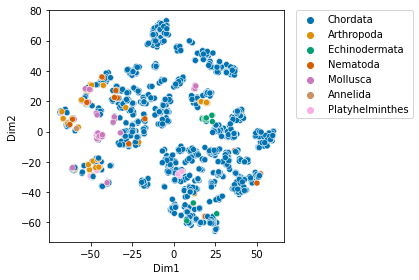

In [ ]:
plot_embeddings(df_animal.target.values.tolist(), label_list = df_animal.Phylum.values.tolist())

With seven phyla, it may be a bit complicated to interpret this graph but the good news is that we can still see some clear glycan clusters! Notably, there is some isolated sets of dark pink dots corresponding to the Mollusca phylum. What is so special about these glycans? Are the observed specificities corresponding to *N*-linked, *O*-linked, or to both types of glycosylations?  <br>

To answer, let's create two datasets to separate *N*-linked and *O*-linked glycosylations. How? By selecting glycans with a **GlcNAc** (*N*-linked) or a **GalNAc** (*O*-linked) monosaccharide at the reducing end. This will help us to identify to which category these isolated clusters correspond to.

In [ ]:
df_N_linked = df_animal[df_animal.target.str.endswith('GlcNAc')]
df_O_linked = df_animal[df_animal.target.str.endswith('GalNAc')]

Everything is ready now. We can perform the plotting step with these two individual datasets.

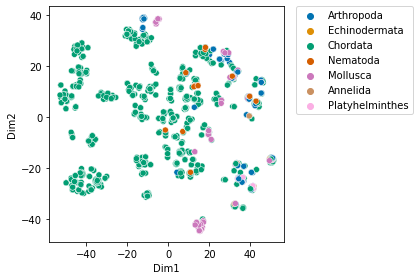

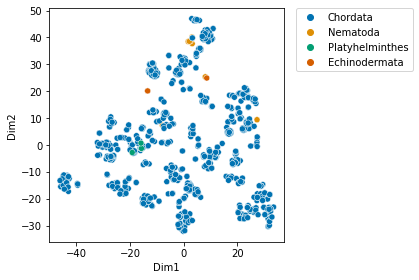

In [ ]:
plot_embeddings(df_N_linked.target.values.tolist(), label_list = df_N_linked.Phylum.values.tolist())
plot_embeddings(df_O_linked.target.values.tolist(), label_list = df_O_linked.Phylum.values.tolist())

Many interesting things to say! First, the *N*-linked glycosylations graph shows the dark pink clusters that we were looking for in addition to some smaller clusters, including one that represents arthropoda glycans (dark blue dots). <br> 

Concerning the second plot, some orange and brown dots are also clustered together and correspond to Nematoda and Echinodermata glycans. Interestingly, this graph also shows the absence of *O*-linked glycans in `df_species` for Arthropoda, Mollusca, and Annelida phyla. <br>

Now, let's focus on Mollusca and their specific *N*-linked glycosylations. We will first convert our data into a count table using `presence_to_matrix` from the `glycowork.motif.processing` module and then visualize the results. A heatmap can be generated using `make_heatmap` from `glycowork.motif.analysis` and the `yticklabels = True` option allows us to display all the labels.

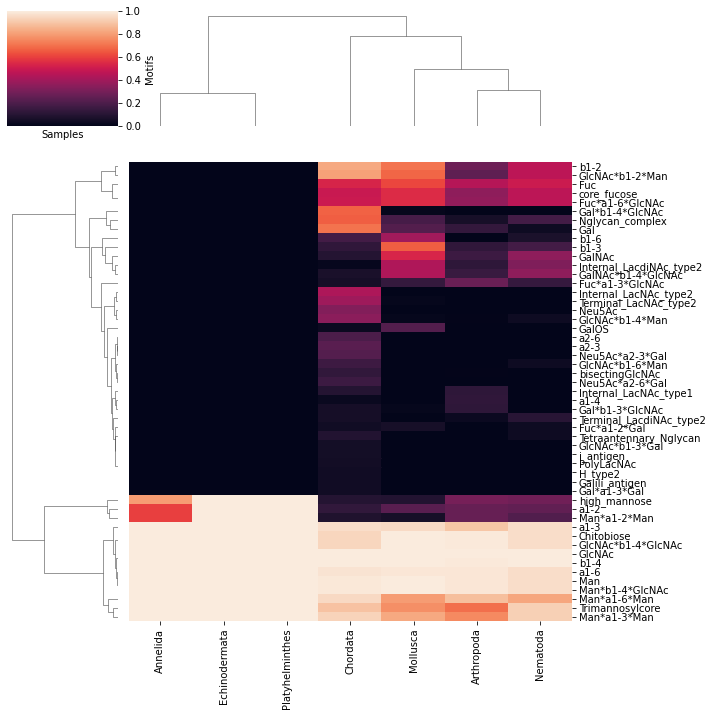

In [ ]:
df_map_N_linked = presence_to_matrix(df_N_linked, label_col_name = 'Phylum')
make_heatmap(df_map_N_linked, mode = 'motif', feature_set = ['known', 'exhaustive'], datatype = 'presence', yticklabels = True)

What an interesting heatmap! The first thing that catches the eye is the absence of a bunch of glycan motifs in the three phyla Annelida, Echinodermata, and Platyhelminthes. Coming back to Mollusca, this heatmap shows for example a relatively high abundance of GalOS (sulfurylated galactose) and b1-3 linkages in these organisms compared to the others. <br>

To visualize which dots from the *N*-linked glycosylations plot correspond to GalOS-containing glycans, we can map them again but with the additional option `shape_feature`. This parameter allows you to transform dots into crosses if the corresponding glycan contains the specified monosaccharide or linkage. 



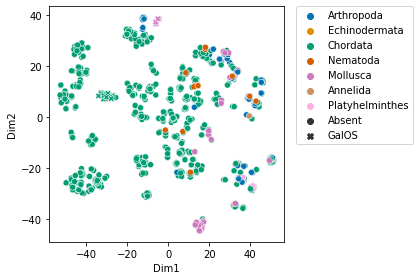

In [ ]:
plot_embeddings(df_N_linked.target.values.tolist(), label_list = df_N_linked.Phylum.values.tolist(), shape_feature = "GalOS")

As you can see, in `df_species`, GalOS-containing glycans exist only in Chordata (green crosses on the left) and Mollusca (dark pink crosses on the top) organisms (in the kingdom Animalia). In this last phylum, they even constitute an isolated cluster. <br> 

As the GalOS monosaccharide displays a singular distribution among animals, we can take a look at its distribution in animal glycans. The `characterize_monosaccharide` from `glycowork.motif.analysis` will be our best ally to learn what are the other monosaccharides to which GalOS is often connected to. <br>

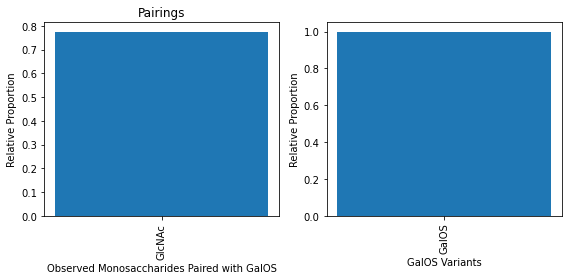

In [ ]:
characterize_monosaccharide('GalOS', rank = 'Kingdom', focus = 'Animalia', modifications = True)

Running this analysis, it appears that GalOS is only found connected to GlcNAc and that it does not display any variant. This is a completely different profile that what was obtained studying xylose in plant glycans! <br>
Let's do one more analysis, in which we turn up the sensitivity of `characterize_monosaccharide` by setting the treshold of observed monosaccharides for the plot to 1.

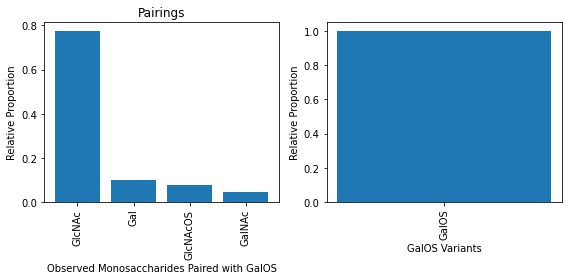

In [ ]:
characterize_monosaccharide('GalOS', rank = 'Kingdom', focus = 'Animalia', modifications = True, thresh = 1)

Interesting, so - quite rarely - sulfurylated galactose in Animalia seems also to be paired with Gal, sulfurylated GlcNAc, and GalNAc!

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_alignment.ipynb.
Converted 02_glycan_data.ipynb.
Converted 03_ml.ipynb.
Converted 04_motif.ipynb.
Converted 05_examples.ipynb.
Converted index.ipynb.
